# EDA — NBA Win Predictor (SQL + ML)

This notebook validates the data pipeline and feature views created by `src/train.py`.

It is designed to be **compatible across DuckDB versions** (no `SHOW VIEWS`).

Prerequisite:
1) Run `python src/train.py --data-dir data --db-path nba.duckdb --artifacts-dir artifacts`
2) Ensure `nba.duckdb` exists in the project root.


## Setup

In [1]:
import duckdb
import pandas as pd
import numpy as np

basepath = "~/NBA-games-ML-pet-project/"
DB_PATH = basepath + "nba.duckdb"  # created by src/train.py
con = duckdb.connect(DB_PATH)

def list_tables(con) -> set[str]:
    df = con.execute("""
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema = 'main' AND table_type = 'BASE TABLE'
    """).df()
    return set(df["table_name"].tolist())

def list_views(con) -> set[str]:
    df = con.execute("""
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema = 'main' AND table_type = 'VIEW'
    """).df()
    return set(df["table_name"].tolist())

views = list_views(con)
tables = list_tables(con)
views, tables

# --- Compatibility shim: create v_teams / v_games if your SQL pipeline did not create them ---
views = list_views(con)
tables = list_tables(con)

if "v_teams" not in views and "teams" in tables:
    con.execute("""
    CREATE OR REPLACE VIEW v_teams AS
    SELECT
      team_id,
      full_name,
      abbreviation,
      city,
      state,
      year_founded
    FROM teams;
    """)
    views.add("v_teams")

if "v_games" not in views and "games" in tables:
    con.execute("""
    CREATE OR REPLACE VIEW v_games AS
    SELECT
      game_id,
      season,
      CAST(game_date AS DATE) AS game_date,
      team_id,
      opponent_team_id,
      CAST(is_home AS BOOLEAN) AS is_home,
      wl,
      CAST(pts AS DOUBLE) AS pts,
      CAST(fg_pct AS DOUBLE) AS fg_pct,
      CAST(fg3_pct AS DOUBLE) AS fg3_pct,
      CAST(ft_pct AS DOUBLE) AS ft_pct,
      CAST(reb AS DOUBLE) AS reb,
      CAST(ast AS DOUBLE) AS ast,
      CAST(tov AS DOUBLE) AS tov
    FROM games;
    """)
    views.add("v_games")

# refresh sets
views = list_views(con)
tables = list_tables(con)



## Pick the dataset view

In [2]:
# Choose which dataset views exist (base vs enriched, and optional named versions)
views = list_views(con)

dataset_view = "v_training_dataset_enriched" if "v_training_dataset_enriched" in views else "v_training_dataset"
named_view = None
if "v_training_dataset_enriched_named" in views:
    named_view = "v_training_dataset_enriched_named"
elif "v_training_dataset_named" in views:
    named_view = "v_training_dataset_named"

dataset_view, named_view


('v_training_dataset_enriched', 'v_training_dataset_enriched_named')

## Quick sanity checks: tables & views

In [3]:
# Display tables and views
con.execute("""
SELECT table_type, table_name
FROM information_schema.tables
WHERE table_schema='main'
ORDER BY table_type, table_name
""").df()


,table_type,table_name
0,BASE TABLE,games
1,BASE TABLE,player_games
2,BASE TABLE,players
3,BASE TABLE,teams
4,VIEW,v_games
5,VIEW,v_player_form
6,VIEW,v_player_games
7,VIEW,v_players
8,VIEW,v_team_form
9,VIEW,v_team_star_features


## Teams sample

In [4]:
con.execute("SELECT * FROM v_teams ORDER BY team_id LIMIT 10").df()


,team_id,full_name,abbreviation,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Atlanta,Georgia,1949
1,1610612738,Boston Celtics,BOS,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Chicago,Illinois,1966
5,1610612742,Dallas Mavericks,DAL,Dallas,Texas,1980
6,1610612743,Denver Nuggets,DEN,Denver,Colorado,1976
7,1610612744,Golden State Warriors,GSW,Golden State,California,1946
8,1610612745,Houston Rockets,HOU,Houston,Texas,1967
9,1610612746,Los Angeles Clippers,LAC,Los Angeles,California,1970


## Games sample

In [5]:
con.execute("SELECT * FROM v_games ORDER BY game_date DESC LIMIT 10").df()


,game_id,season,game_date,team_id,opponent_team_id,is_home,wl,pts,fg_pct,fg3_pct,ft_pct,reb,ast,tov
0,42400407,2024,2025-06-22,1610612754,1610612760,False,L,91.0,0.414,0.393,0.759,45.0,17.0,21.0
1,42400407,2024,2025-06-22,1610612760,1610612754,True,W,103.0,0.402,0.275,0.710,40.0,20.0,7.0
2,42400407,2024,2025-06-22,1610612754,1610612760,False,L,91.0,0.414,0.393,0.759,45.0,17.0,21.0
3,42400407,2024,2025-06-22,1610612760,1610612754,True,W,103.0,0.402,0.275,0.710,40.0,20.0,7.0
4,42400407,2024,2025-06-22,1610612754,1610612760,False,L,91.0,0.414,0.393,0.759,45.0,17.0,21.0
5,42400407,2024,2025-06-22,1610612760,1610612754,True,W,103.0,0.402,0.275,0.710,40.0,20.0,7.0
6,42400407,2024,2025-06-22,1610612754,1610612760,False,L,91.0,0.414,0.393,0.759,45.0,17.0,21.0
7,42400407,2024,2025-06-22,1610612760,1610612754,True,W,103.0,0.402,0.275,0.710,40.0,20.0,7.0
8,42400406,2024,2025-06-19,1610612754,1610612760,True,W,108.0,0.413,0.357,0.680,46.0,23.0,10.0
9,42400406,2024,2025-06-19,1610612760,1610612754,False,L,91.0,0.419,0.267,0.808,41.0,14.0,21.0


## Named view preview (if available)
Named views include team names/abbreviations for readability.

In [6]:
if named_view:
    con.execute(f"SELECT game_date, team_abbr, opponent_abbr, is_home, y_win FROM {named_view} ORDER BY game_date DESC LIMIT 15").df()
else:
    "Named view not found. (Optional: sql/05_named_views.sql creates it.)"


## Training dataset preview

In [7]:
df = con.execute(f"SELECT * FROM {dataset_view}").df()
df["game_date"] = pd.to_datetime(df["game_date"])
df = df.sort_values("game_date").reset_index(drop=True)
df.head()


,game_id,season,game_date,team_id,opponent_team_id,is_home,y_win,rest_days,pts_avg_l5,reb_avg_l5,...,opp_fg_pct_avg_l5,opp_fg3_pct_avg_l5,opp_ft_pct_avg_l5,opp_winrate_l5,star_pts_avg_l5_sum,star_min_avg_l5_avg,star_pm_avg_l5_avg,opp_star_pts_avg_l5_sum,opp_star_min_avg_l5_avg,opp_star_pm_avg_l5_avg
0,22400081,2024,2024-10-25,1610612754,1610612752,False,0,2,115.0,39.0,...,0.551,0.367,0.750,0.0,58.0,32.000000,14.333333,60.0,28.666667,-24.666667
1,22400080,2024,2024-10-25,1610612765,1610612739,False,0,2,109.0,38.0,...,0.586,0.467,0.769,1.0,59.0,32.333333,-4.333333,65.0,25.333333,27.000000
2,22400085,2024,2024-10-25,1610612747,1610612756,True,1,3,110.0,46.0,...,0.487,0.395,0.735,1.0,70.0,36.000000,4.666667,64.0,38.000000,-2.333333
3,22400086,2024,2024-10-25,1610612740,1610612757,False,1,2,123.0,42.0,...,0.391,0.235,0.800,0.0,69.0,29.666667,11.666667,53.0,29.333333,-20.000000
4,22400078,2024,2024-10-25,1610612761,1610612755,True,1,2,106.0,38.0,...,0.418,0.258,0.704,0.0,44.0,22.666667,-15.666667,59.0,31.000000,-14.666667


## Dataset size & date coverage

In [8]:
pd.DataFrame({
    "rows": [len(df)],
    "start_date": [df["game_date"].min().date()],
    "end_date": [df["game_date"].max().date()],
    "num_teams": [df["team_id"].nunique()],
    "num_games": [df["game_id"].nunique()],
})


,rows,start_date,end_date,num_teams,num_games
0,4956,2024-10-25,2025-06-22,30,1298


## Target distribution

In [9]:
df["y_win"].value_counts().rename("count").to_frame().assign(share=lambda x: x["count"]/x["count"].sum())


,count,share
y_win,,
0,2480,0.500404
1,2476,0.499596


## Missingness (top 25 columns)
Rolling features can be missing early in a team’s season/history.

In [10]:
miss = (df.isna().mean().sort_values(ascending=False) * 100).head(25).to_frame("missing_%")
miss


,missing_%
game_id,0.0
season,0.0
game_date,0.0
team_id,0.0
opponent_team_id,0.0
is_home,0.0
y_win,0.0
rest_days,0.0
pts_avg_l5,0.0
reb_avg_l5,0.0


## Leakage sanity check (rolling windows)
Rolling features are computed using past games only: `ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING`.
We spot-check one team’s rolling values and compare against raw points.

In [11]:
team_id = int(df["team_id"].value_counts().index[0])
tf = con.execute(f"""
    SELECT game_date, team_id, wl, pts, pts_avg_l5, winrate_l5, tov, tov_avg_l5
    FROM v_team_form
    WHERE team_id = {team_id}
    ORDER BY game_date
    LIMIT 60
""").df()
tf["game_date"] = pd.to_datetime(tf["game_date"])
tf.tail(20)


,game_date,team_id,wl,pts,pts_avg_l5,winrate_l5,tov,tov_avg_l5
40,2025-01-17,1610612760,L,98.0,127.2,0.8,15.0,12.8
41,2025-01-19,1610612760,W,127.0,122.4,0.8,11.0,13.2
42,2025-01-22,1610612760,W,123.0,122.6,0.8,10.0,12.4
43,2025-01-23,1610612760,L,115.0,120.0,0.8,12.0,11.8
44,2025-01-26,1610612760,W,118.0,119.4,0.6,7.0,10.8
45,2025-01-29,1610612760,L,109.0,116.2,0.6,11.0,11.0
46,2025-02-01,1610612760,W,144.0,118.4,0.6,11.0,10.2
47,2025-02-03,1610612760,W,125.0,121.8,0.6,17.0,10.2
48,2025-02-05,1610612760,W,140.0,122.2,0.6,5.0,11.6
49,2025-02-07,1610612760,W,121.0,127.2,0.8,12.0,10.2


## Simple baseline
A quick heuristic baseline: predict win if `winrate_l5 > opp_winrate_l5`.
This is not ML—just a reference point.

In [12]:
baseline_pred = (df["winrate_l5"] > df["opp_winrate_l5"]).astype(int)
baseline_acc = (baseline_pred == df["y_win"]).mean()
baseline_acc


np.float64(0.7423325262308313)

## Correlations (numeric)
Quick scan to see which variables are most associated with `y_win`.

In [13]:
num = df.select_dtypes(include=[np.number]).copy()
corr = num.corr(numeric_only=True)
corr["y_win"].sort_values(ascending=False).head(20).to_frame("corr_with_y_win")


,corr_with_y_win
y_win,1.000000
winrate_l5,0.502710
star_pm_avg_l5_avg,0.474738
fg_pct_avg_l5,0.334806
pts_avg_l5,0.324975
opp_tov_avg_l5,0.308409
fg3_pct_avg_l5,0.292638
ft_pct_avg_l5,0.250501
ast_avg_l5,0.238525
rest_days,0.165702


## A few plots (matplotlib)

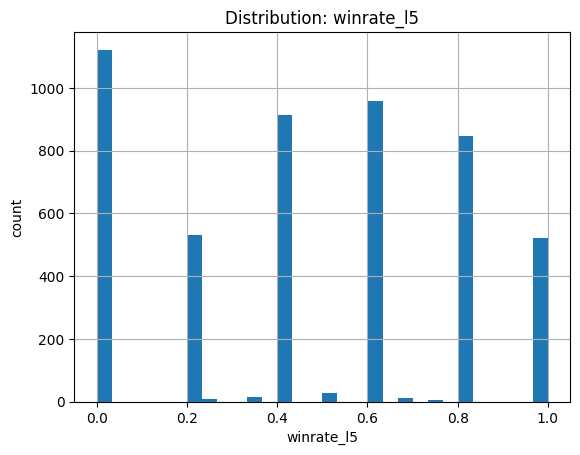

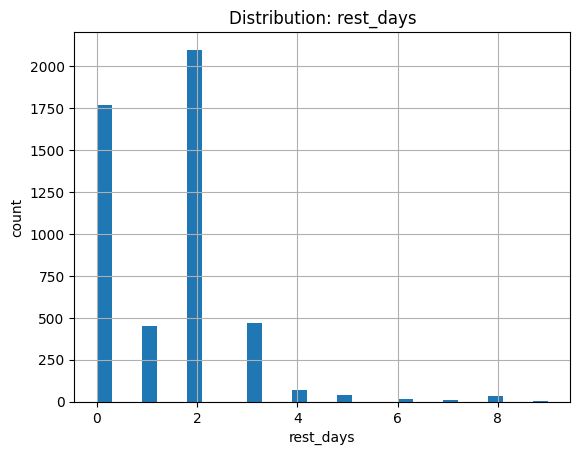

In [14]:
import matplotlib.pyplot as plt

# Win rate last-5 distribution
plt.figure()
df["winrate_l5"].dropna().hist(bins=30)
plt.title("Distribution: winrate_l5")
plt.xlabel("winrate_l5")
plt.ylabel("count")
plt.show()

# Rest days distribution
plt.figure()
df["rest_days"].dropna().hist(bins=30)
plt.title("Distribution: rest_days")
plt.xlabel("rest_days")
plt.ylabel("count")
plt.show()


## Head-to-head summary query (example)
This is a portfolio-style SQL query showing you can analyze pairings.

In [15]:
# pick two team IDs from v_teams
teams_df = con.execute("SELECT team_id, abbreviation, full_name FROM v_teams ORDER BY team_id").df()
teams_df.head(10)


,team_id,abbreviation,full_name
0,1610612737,ATL,Atlanta Hawks
1,1610612738,BOS,Boston Celtics
2,1610612739,CLE,Cleveland Cavaliers
3,1610612740,NOP,New Orleans Pelicans
4,1610612741,CHI,Chicago Bulls
5,1610612742,DAL,Dallas Mavericks
6,1610612743,DEN,Denver Nuggets
7,1610612744,GSW,Golden State Warriors
8,1610612745,HOU,Houston Rockets
9,1610612746,LAC,Los Angeles Clippers


In [16]:
# example: pick first two team_ids shown above
team_a = int(teams_df.iloc[0]["team_id"])
team_b = int(teams_df.iloc[1]["team_id"])

h2h = con.execute("""
    SELECT
      COUNT(*) AS games_count,
      SUM(CASE WHEN wl='W' THEN 1 ELSE 0 END) AS team_a_wins,
      SUM(CASE WHEN wl='L' THEN 1 ELSE 0 END) AS team_a_losses
    FROM v_games
    WHERE team_id = ? AND opponent_team_id = ?
""", [team_a, team_b]).df()

h2h


,games_count,team_a_wins,team_a_losses
0,3,2.0,1.0


In [17]:
con.close()

## Next
Proceed to `02_modeling.ipynb` to train ML models with a time-based split and compare results.